In [62]:
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller  # For spelling correction
import time
from bs4 import BeautifulSoup
import html
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import random
from sklearn.neighbors import NearestNeighbors


In [63]:
train_data=pd.read_csv("Dataset/train.csv")
train_data.drop(columns=['Id','CreationDate', 'Y'],inplace=True)
valid_data=pd.read_csv("Dataset/valid.csv")
valid_data.drop(columns=['Id','CreationDate', 'Y'],inplace=True)

# Phase1: Preprocessing

In [64]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
# spell = Speller()  # Initialize spelling corrector

### Functions

Normalization rules


In [65]:
CONTRACTIONS = {
    "can't": "cannot",
    "won't": "will not",
    "n't": " not",
    "'re": " are",
    "'s": " is",
    "'ll": " will",
    "'ve": " have",
    "'d": " would",
    "'m": " am"
}
urlptr = r'((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)'
alhptr = '[^a-zA-Z0-9]'
sqcptr = r'(.)\1\1+'
rplptr = r'\1\1'

##### Normalize Text

In [66]:
def normalize_text(text):
    """Normalize text by expanding contractions."""
    for contraction, expansion in CONTRACTIONS.items():
        text = re.sub(contraction, expansion, text)
    return text

##### Remove Links

In [67]:
def remove_links(text):
    """Remove URLs from the text."""
    text = text.lower()
    text = re.sub(urlptr, ' URL', text)      
    text = re.sub(alhptr, ' ', text)
    text = re.sub(sqcptr, rplptr, text)
    return text

Remove Code Blocks

In [68]:
def remove_code_blocks(text):
    """Remove code snippets enclosed in backticks or indented lines."""
    text = re.sub(r"```.*?```", "", text, flags=re.DOTALL)  # Multi-line code blocks
    text = re.sub(r"`.*?`", "", text)  # Inline code snippets
    return text

##### Reduce Repeated Characters

In [69]:
def reduce_repeated_characters(text):
    """Reduce repeated characters to a maximum of two consecutive characters."""
    return re.sub(r"(.)\1{2,}", r"\1\1", text)

##### Remove Numbers

In [70]:
def remove_numbers(text):
    """Remove all numeric characters from the text."""
    return re.sub(r"\d+", "", text)

##### Preprocess HTML

In [71]:
def preprocess_html(text):
    """Preprocess HTML/XML structured text."""
    # Parse HTML content
    soup = BeautifulSoup(text, "html.parser")
    
    # Extract text and replace code blocks with placeholders
    for code in soup.find_all("code"):
        code.replace_with("<CODE>")
    
    # Remove blockquotes or replace with placeholder
    for blockquote in soup.find_all("blockquote"):
        blockquote.replace_with("<ERROR>")
    
    # Get cleaned text
    text = soup.get_text()
    
    # Decode HTML entities (e.g., &lt; -> <)
    text = html.unescape(text)
    
    # Normalize line breaks
    text = " ".join(text.split())
    
    return text

##### Preprocess Text

In [72]:
def preprocess_text(text):
    """Apply full preprocessing pipeline to text."""
    if not text or pd.isna(text):  # Handle None or NaN
        return ""
    
    # print("Original Text:", text)
    
    # Preprocess HTML/XML content
    text = preprocess_html(text)
    # print("After HTML Processing:", text)

    # Preprocess removing codeblocks
    text = remove_code_blocks(text)
    # print("After Code removing Processing:", text)

    # Preprocess removing links
    text = remove_links(text)
    # print("After Code removing links:", text)

    # Preprocess removing numbers
    text = remove_numbers(text)
    # print("After Code removing numbers:", text)
    
    # Normalize contractions
    text = normalize_text(text)
    # print("After Contraction Normalization:", text)
    
    # Lowercase text
    text = text.lower()
    # print("After Lowercasing:", text)
    
    # Tokenize
    tokens = word_tokenize(text)
    # print("After Tokenization:", tokens)
    
    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # print("After Lemmatization:", tokens)
    
    # Optional: Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # print("After Stopword Removal:", tokens)
    
    # Reconstruct text
    preprocessed_text = " ".join(tokens)
    # print("Final Preprocessed Text:", preprocessed_text)
    
    return preprocessed_text
   

##### Clean Tags


In [73]:
def clean_tags(s):
    '''
    This function converts the Tags in a space separated sentence.
    '''
    s=str(s)
    n=len(s)
    ls=[]
    for i in range(0,n):
        if s[i]=='<':
            for j in range(i+1,n):
                if s[j]=='>':
                    ls.append(s[i+1:j])
                    i=j+1
                    break
    s=" "
    s=s.join(ls)
    return s

parallel preprocessing

In [74]:
def parallel_preprocessing(column):
    return Parallel(n_jobs=-1)(delayed(preprocess_text)(text) for text in column)
    
def parallel_clean_tags(column):
    return Parallel(n_jobs=-1)(delayed(clean_tags)(tag) for tag in column)     

### Preprocess

Send train data to parallel preprocessing and parallel clean tags functions

In [75]:
train_data["Preprocessed_Title"] = parallel_preprocessing(train_data["Title"])
train_data["Preprocessed_Body"] = parallel_preprocessing(train_data["Body"])
train_data["Preprocessed_Tag"] = parallel_clean_tags(train_data["Tags"])

output_path = "preprocessed_dataset.csv"
train_data.to_csv(output_path, index=False)

show train data's table after preprocessing

In [76]:
train_data.tail()

,Title,Body,Tags,Preprocessed_Title,Preprocessed_Body,Preprocessed_Tag
44995,Convert List<String> to string C# - asp.net - ...,<p>I am new to this and I am asking for help t...,<c#><asp.net><sql-server>,convert list string c asp net sql server,new asking help convert string type data made ...,c# asp.net sql-server
44996,Does Python execute code from the top or botto...,<p>I am working on learning Python and was won...,<python>,doe python execute code top bottom script,working learning python wa wondering way scrip...,python
44997,how to change payment date in Azure?,<p>It looks like it costs 8 days per month in ...,<azure><billing>,change payment date azure,look like cost day per month azure change bill...,azure billing
44998,how to implement fill in the blank in Swift,"<p>""I _____ any questions.""</p>\n\n<p>I want t...",<ios><swift>,implement fill blank swift,question want implement quiz click parenthesis...,ios swift
44999,How can I make a c# application outside of vis...,<p>I'm very new to programming and I'm teachin...,<c#><visual-studio>,make c application outside visual studio,new programming teaching made calculator calcu...,c# visual-studio


# Phase 2: Word2Vec and Similarity Retrieval

## Functions

##### Plot Random Vectors 3D

In [77]:
def plot_random_vectors_3d(doc_vectors_2d, n=100):
    # Select random indices
    indices = random.sample(range(len(doc_vectors_2d)), n)
    
    # Extract the selected vectors
    selected_vectors = doc_vectors_2d[indices]
    
    # Extract coordinates
    x = selected_vectors[:, 0]
    y = selected_vectors[:, 1]
    z = selected_vectors[:, 2]

    # Plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(x, y, z, alpha=0.6, c=range(n), cmap='viridis')
    
    # Add labels
    for i, idx in enumerate(indices):
        ax.text(x[i], y[i], z[i], str(idx), fontsize=8, alpha=0.7)

    ax.set_title(f"Random {n} Document Vectors (3D PCA)")
    ax.set_xlabel("PCA Dimension 1")
    ax.set_ylabel("PCA Dimension 2")
    ax.set_zlabel("PCA Dimension 3")
    plt.show()

##### Plot Word Embeddings

In [78]:
def plot_word_embeddings(reduced_vectors_3d, words):
    # Plot the word embeddings in 3D
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')

    # Plot each word as a point in 3D space
    for i, word in enumerate(words[:150]):  # Plot only the first 100 words for clarity
        x, y, z = reduced_vectors_3d[i]
        ax.scatter(x, y, z, c='blue', s=30)
        ax.text(x, y, z, word, fontsize=10)

    # Set labels and title
    ax.set_title("3D Word Embeddings Visualization")
    ax.set_xlabel("PCA Component 1")
    ax.set_ylabel("PCA Component 2")
    ax.set_zlabel("PCA Component 3")

    plt.show()

##### Calculate Average Vectors

In [79]:
def calculate_average_vectors(texts, word2vec_model):
    vector_size = word2vec_model.vector_size
    doc_vectors = []

    for doc in texts:
        word_vectors = [
            word2vec_model.wv[word]
            for word in doc.split() if word in word2vec_model.wv
        ]
        
        if word_vectors:
            # Average the word vectors for the document
            doc_vector = np.mean(word_vectors, axis=0)
        else:
            # If no valid words, use a zero vector
            doc_vector = np.zeros(vector_size)
        
        doc_vectors.append(doc_vector)
    
    return np.array(doc_vectors)

## Word Vectors

##### Creating Word embeddings

In [80]:
train_data["Combined_Text"] = train_data["Preprocessed_Title"] + " " + train_data["Preprocessed_Body"]
tokenized_data = [text.split() for text in train_data["Combined_Text"]]


In [81]:
word2vec_model = Word2Vec(sentences=tokenized_data, vector_size=150, window=5, min_count=2, workers=2,sg=1, epochs=50)
word2vec_model.save("word2vec_stackoverflow.model")


In [82]:
# word2vec_model=Word2Vec.load('word2vec_stackoverflow.model')
words = list(word2vec_model.wv.index_to_key)
vectors = word2vec_model.wv[words]


#### Testing Vectors

In [83]:
word2vec_model.wv.most_similar('gmail')[:10]

[('email', 0.6617672443389893),
 ('satheezkumar', 0.6415207386016846),
 ('rediff', 0.6091378331184387),
 ('mailgun', 0.6057800650596619),
 ('wex', 0.6016517281532288),
 ('gsuite', 0.6000697612762451),
 ('rohanfile', 0.5981631278991699),
 ('abcdf', 0.5897029638290405),
 ('mail', 0.5784346461296082),
 ('seleniumtest', 0.5765087604522705)]

In [84]:
word2vec_model.wv.most_similar('python')[:10]

[('pyenv', 0.5758589506149292),
 ('guppy', 0.5722858905792236),
 ('pyparsing', 0.57035893201828),
 ('numpy', 0.5672104954719543),
 ('pypdf', 0.5635924935340881),
 ('komodo', 0.547966480255127),
 ('mkl', 0.5477471351623535),
 ('multiplataform', 0.5427808165550232),
 ('argparser', 0.541533350944519),
 ('pyth', 0.5366126298904419)]

In [85]:
word2vec_model.wv.most_similar('google')[:10]

[('appscript', 0.6758095026016235),
 ('appindexing', 0.638527512550354),
 ('hangout', 0.6181865930557251),
 ('ndb', 0.6133236289024353),
 ('aww', 0.5981616377830505),
 ('shiv', 0.5977445244789124),
 ('xjr', 0.5939909815788269),
 ('appinvite', 0.587768018245697),
 ('zza', 0.5862111449241638),
 ('cameraposition', 0.5849073529243469)]

In [117]:
word2vec_model.wv.most_similar('mobile')[:10]

[('phone', 0.5538870096206665),
 ('istablet', 0.5434908866882324),
 ('textboxt', 0.5346812605857849),
 ('invoiceperiod', 0.5242841839790344),
 ('devicemap', 0.5218595266342163),
 ('mart', 0.517998456954956),
 ('inviting', 0.5160731077194214),
 ('onclkds', 0.5152467489242554),
 ('zen', 0.512763500213623),
 ('device', 0.5095327496528625)]

In [86]:
 word2vec_model.wv.doesnt_match(['python', 'pyenv', 'java', 'phone'])

'phone'

### Plot 3D

In [87]:
pca = PCA(n_components=3)
reduced_vectors_3d = pca.fit_transform(vectors)

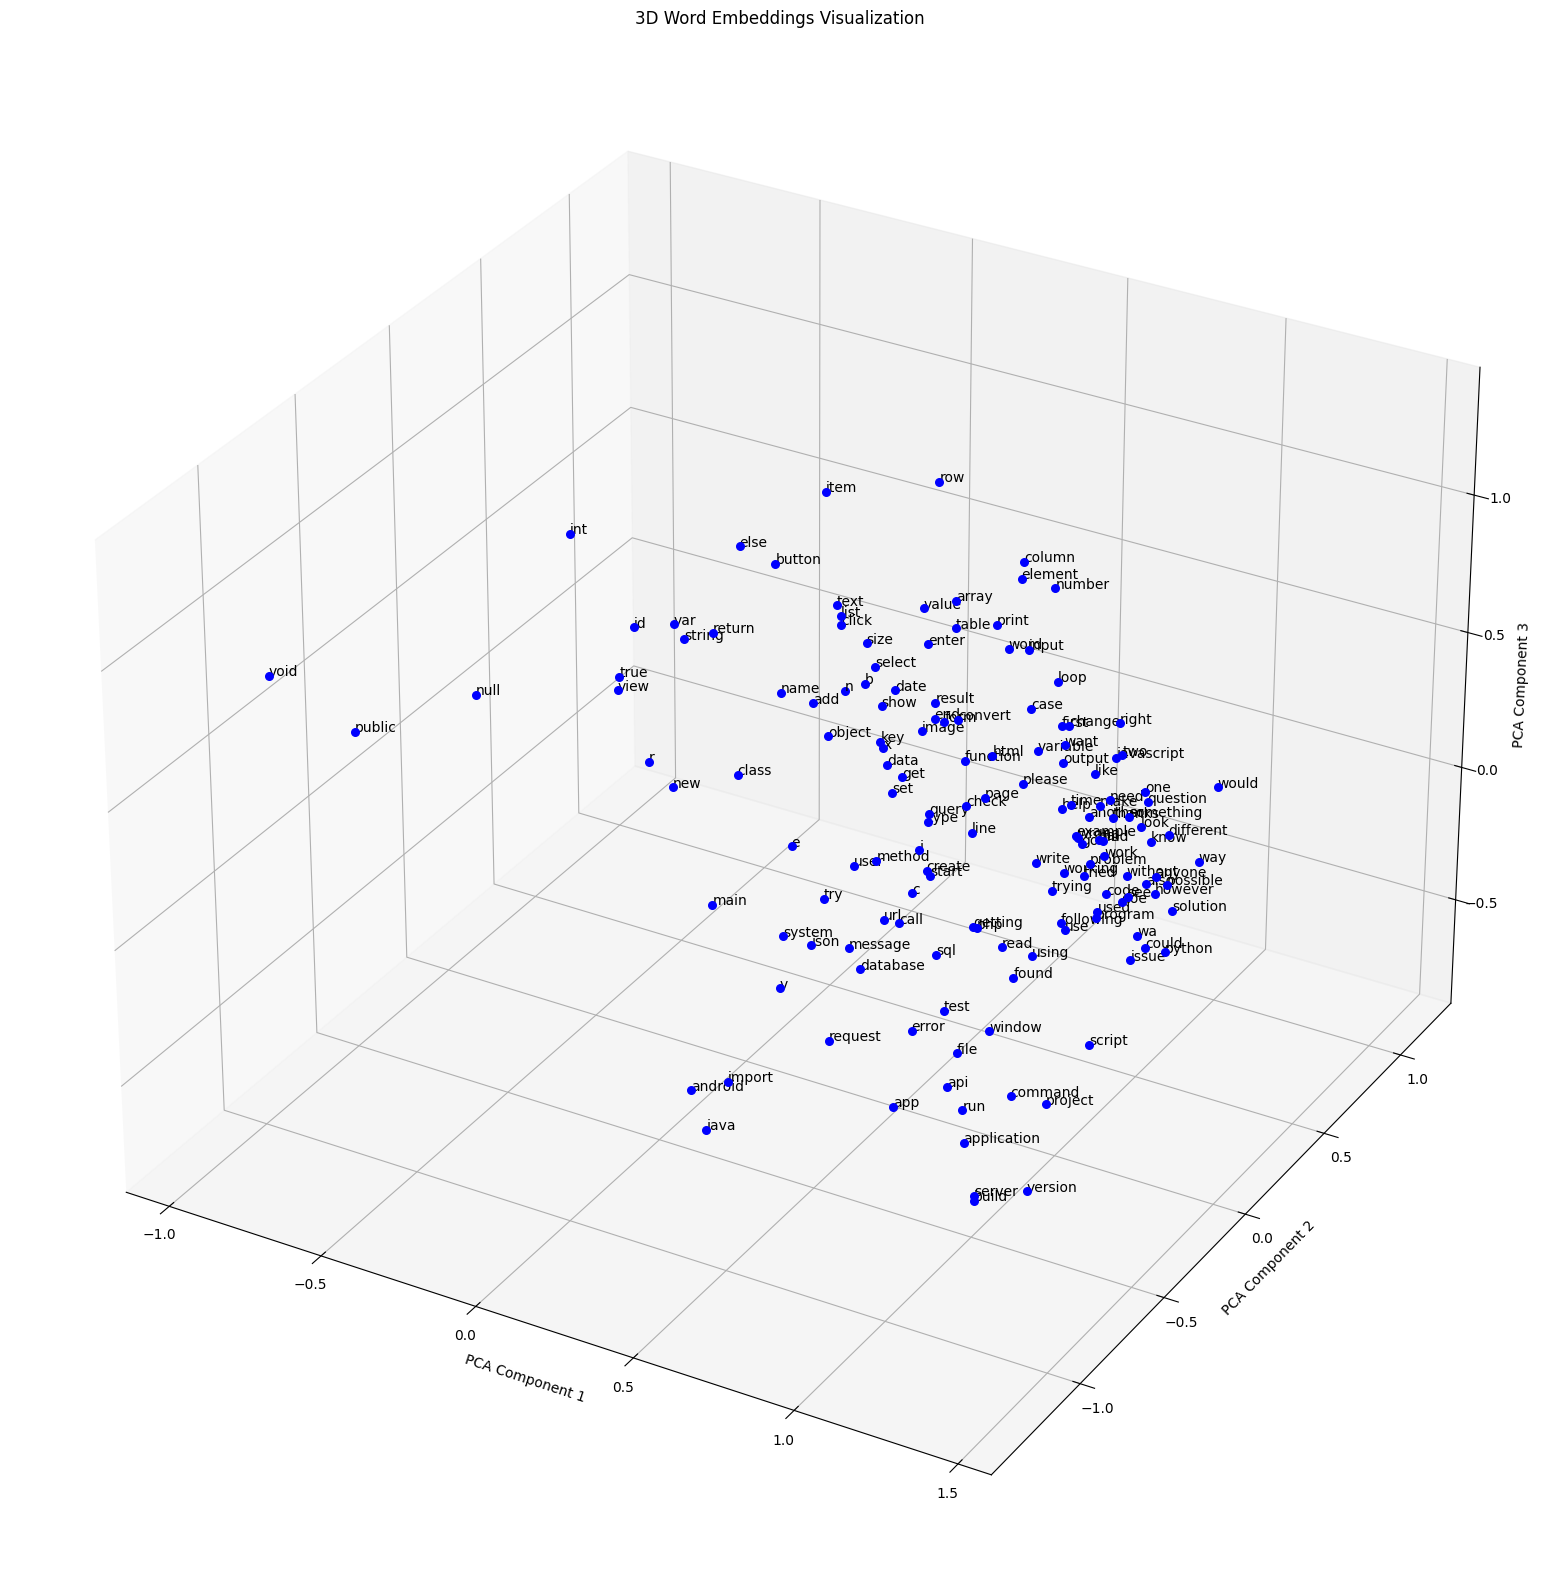

In [88]:
plot_word_embeddings(reduced_vectors_3d, words)

## Document Vectors

##### Creating Document Vectors

In [94]:
texts = train_data["Combined_Text"].tolist()
doc_vectors = calculate_average_vectors(texts, word2vec_model)

### Plot Random Vectors 3D

In [95]:
pca = PCA(n_components=3)
reduced_doc_vectors_3d = pca.fit_transform(doc_vectors)

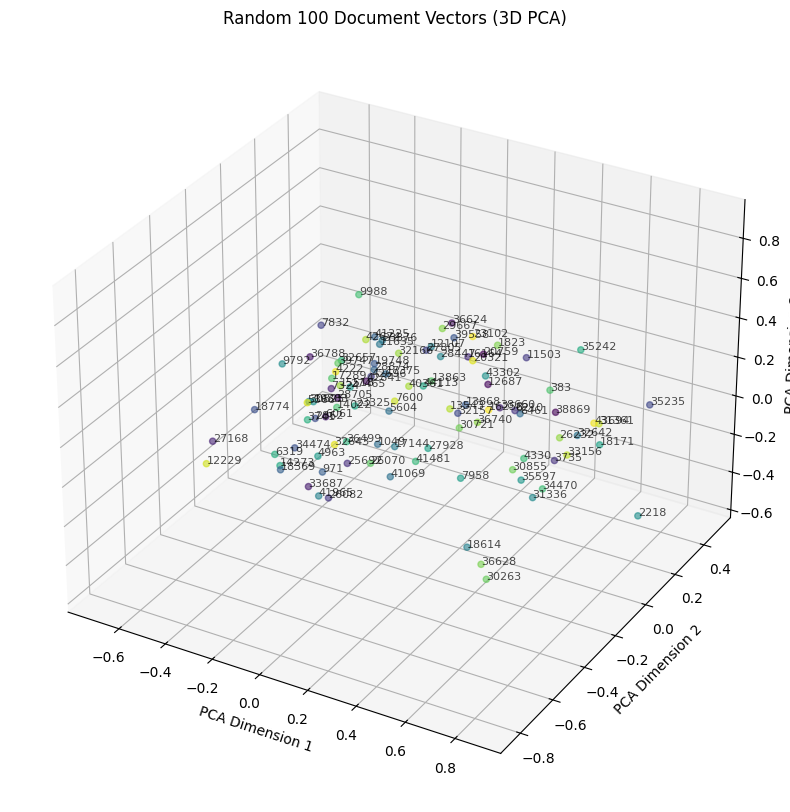

In [96]:
plot_random_vectors_3d(reduced_doc_vectors_3d)

In [121]:
train_data.iloc[[18614,36628]]

,Title,Body,Tags,Preprocessed_Title,Preprocessed_Body,Preprocessed_Tag,Combined_Text
18614,when I am moving jck 1.5 code to jdk 1.7 plato...,when I am moving jdk 1.5 code to jdk 1.7 platf...,<java>,moving jck code jdk platorm time getting class...,moving jdk code jdk platform time getting clas...,java,moving jck code jdk platorm time getting class...
36628,input a directory to java to be proceed,"> I have a problem in here, whenever I entered...",<java><filereader>,input directory java proceed,problem whenever entered directory path copy c...,java filereader,input directory java proceed problem whenever ...


## Query

### Averaging

In [97]:
def find_most_similar(query, model, train_data, top_n=5):
    preprocessed_query=preprocess_text(query)
    # Generate the query vector
    query_words = [word for word in preprocessed_query.split() if word in model.wv]
    if not query_words:
        raise ValueError("None of the query words are in the Word2Vec vocabulary.")
    
    query_vector = np.mean([model.wv[word] for word in query_words], axis=0).reshape(1, -1)
    similarities = []

    # Compare query vector with document vectors
    for i, tokens in enumerate(train_data['Combined_Text']):
        doc_words = [word for word in tokens.split() if word in model.wv]
        if not doc_words:  # Skip documents with no valid words
            continue

        doc_vector = np.mean([model.wv[word] for word in doc_words], axis=0).reshape(1, -1)
        similarity = cosine_similarity(query_vector, doc_vector)[0][0]
        similarities.append((i, similarity))

    # Sort by similarity and return the top N results
    most_similar = sorted(similarities, key=lambda x: x[1], reverse=True)[:top_n]

    answer=[(train_data.iloc[i]['Preprocessed_Body'], score) for i, score in most_similar]
    print("\nQuery:", preprocessed_query)
    
    print("\nMost similar questions:")
    for i, (question, score) in enumerate(answer):
        print(f"{i+1}. {question} (Similarity: {score:.2f})")
        
    


In [98]:
query = "Most Pythonic way to kill a thread after some period of timer"
find_most_similar(query, word2vec_model, train_data)


Query: pythonic way kill thread period timer

Most similar questions:
1. would accurate solution multiple consecutive timer java android word best option delay next piece code current timer ha finished background information question unclear practice coding would like create free app w ad help practice freediving basic idea several timer run example minute breath hold breath minute minute breath hold breath minute second minute breath hold breath minute second second usually round breath holding lead consecutive timer first thought use timer class know pause code timer finished timer ran simultaneously read countdownlatch handler enough experience judge would best purpose python version used sleep worked fine longer timer wa inaccurate second problem another option believe use regular timer run loop displayed text know infinite loop would crash application interfere timer accuracy ha negative side effect help thought would appreciated thanks (Similarity: 0.80)
2. want call function ce

### Tf idf


In [123]:
def find_most_similar_tfidf(query, model, train_data, text_column, top_n=5):
    # Fit TF-IDF vectorizer on the dataset
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(train_data[text_column])
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Preprocess the query
    preprocessed_query = preprocess_text(query)
    query_words = [word for word in preprocessed_query.split() if word in model.wv]
    if not query_words:
        raise ValueError("None of the query words are in the Word2Vec vocabulary.")
    
    # Calculate the TF-IDF scores for the query
    query_tfidf_scores = dict(zip(feature_names, tfidf_vectorizer.transform([preprocessed_query]).toarray()[0]))
    query_vector = np.mean(
        [model.wv[word] * query_tfidf_scores[word] for word in query_words if word in query_tfidf_scores],
        axis=0
    ).reshape(1, -1)

    similarities = []

    # Compare query vector with document vectors
    for i, row in train_data.iterrows():
        text = row[text_column]
        doc_words = [word for word in text.split() if word in model.wv]
        if not doc_words:  # Skip documents with no valid words
            continue
        
        # Get TF-IDF scores for the document
        doc_tfidf_scores = dict(zip(feature_names, tfidf_matrix[i].toarray()[0]))
        
        # Calculate weighted document vector
        doc_vector = np.mean(
            [model.wv[word] * doc_tfidf_scores[word] for word in doc_words if word in doc_tfidf_scores],
            axis=0
        ).reshape(1, -1)

        # Compute cosine similarity
        similarity = cosine_similarity(query_vector, doc_vector)[0][0]
        similarities.append((i, similarity))
    
    # Sort by similarity and return the top N results
    most_similar = sorted(similarities, key=lambda x: x[1], reverse=True)[:top_n]
    answer = [(train_data.iloc[i]['Preprocessed_Body'], score) for i, score in most_similar]
    print("\nQuery:", preprocessed_query)
    print("\nMost similar questions:")
    for i, (question, score) in enumerate(answer):
        print(f"{i+1}. {question} (Similarity: {score:.2f})")
        


In [124]:
query = "Most Pythonic way to kill a thread after some period of timer"
find_most_similar_tfidf(query, word2vec_model, train_data,"Combined_Text")


Query: pythonic way kill thread period timer

Most similar questions:
1. would accurate solution multiple consecutive timer java android word best option delay next piece code current timer ha finished background information question unclear practice coding would like create free app w ad help practice freediving basic idea several timer run example minute breath hold breath minute minute breath hold breath minute second minute breath hold breath minute second second usually round breath holding lead consecutive timer first thought use timer class know pause code timer finished timer ran simultaneously read countdownlatch handler enough experience judge would best purpose python version used sleep worked fine longer timer wa inaccurate second problem another option believe use regular timer run loop displayed text know infinite loop would crash application interfere timer accuracy ha negative side effect help thought would appreciated thanks (Similarity: 0.76)
2. working game one main

# Phase 3: Tagging


##### Load model and word vectors

## Functions

In [101]:
word2vec_model = Word2Vec.load('word2vec_stackoverflow.model')
word_vectors = word2vec_model.wv

##### Text To Vector

In [102]:
def text_to_vector(text):
    words = text.split()
    return np.mean([word_vectors[word] for word in words if word in word_vectors], axis=0)

##### Suggested Tags by Distance

In [103]:
def get_suggested_tags_by_distance(indices, y_train, document_vectors, word2vec_model, top_n=5):
    suggested_tags = []
    
    for doc_idx, neighbor_indices in enumerate(indices):
        # Collect tags from nearest neighbors
        neighbor_tags = {tag for i in neighbor_indices for tag in y_train[i]}
        
        # Initialize tag similarity dictionary
        tag_similarities = {}
        
        # Calculate similarity for each tag
        for tag in neighbor_tags:
            words = tag.split()  # Split tags into individual words
            word_similarities = []
            
            for word in words:
                if word in word2vec_model.wv:
                    word_vector = word2vec_model.wv[word]
                    similarity = cosine_similarity([document_vectors[doc_idx]], [word_vector])[0, 0]
                    word_similarities.append(similarity)
            
            # Aggregate similarity for the tag (e.g., max similarity across words in the tag)
            if word_similarities:
                tag_similarities[tag] = max(word_similarities)
        
        # Sort tags by similarity and select the top_n
        top_tags = sorted(tag_similarities, key=tag_similarities.get, reverse=True)[:top_n]
        suggested_tags.append(top_tags)
    
    return suggested_tags

##### Calculate Accuracy

In [104]:
def calculate_accuracy(predicted_tags, y_test_list):

    successful_matches = 0  
    total_samples = len(y_test_list) 
    for predicted, actual in zip(predicted_tags, y_test_list):
        if set(predicted).intersection(set(actual)): 
            successful_matches += 1

    accuracy = successful_matches / total_samples 
    return accuracy

##### Show Prediction Samples

In [105]:
def show_prediction_samples(true_tags, predicted_tags, num_samples=5):
    successful_predictions = []
    failed_predictions = []

    for true, predicted in zip(true_tags, predicted_tags):
        if set(true).intersection(set(predicted)):
            successful_predictions.append((true, predicted))
        else:
            failed_predictions.append((true, predicted))

    print(f"\n Correct prediction ({len(successful_predictions)}):")
    for i, (true, predicted) in enumerate(successful_predictions[:num_samples], 1):
        print(f"{i}. True : {true}, Predicted : {predicted}")

    print(f"\n Faild prediction ({len(failed_predictions)}):")
    for i, (true, predicted) in enumerate(failed_predictions[:num_samples], 1):
        print(f"{i}. True : {true}, Predicted : {predicted}")


## Preprocessing

##### Prepare validation data and select 10% as sample data 

In [106]:
# Determine 10% of the dataset
sample_size = int(0.1 * len(valid_data))
sampled_data = valid_data.sample(n=sample_size, random_state=42)  # Set a seed for reproducibility


In [107]:
# Apply preprocessing to the sampled subset
sampled_data["Preprocessed_Title"] = parallel_preprocessing(sampled_data["Title"])
sampled_data["Preprocessed_Body"] = parallel_preprocessing(sampled_data["Body"])
sampled_data["Preprocessed_Tag"] = parallel_clean_tags(sampled_data["Tags"])
sampled_data["Combined_Text"] = sampled_data["Preprocessed_Title"] + " " + sampled_data["Preprocessed_Body"]

In [108]:
sampled_data.tail()

,Title,Body,Tags,Preprocessed_Title,Preprocessed_Body,Preprocessed_Tag,Combined_Text
2655,cluster and non-cluster index seeking increase...,dears\r\nI have a store procedure which takes ...,<sql><sql-server><stored-procedures><indexing>...,cluster non cluster index seeking increase exe...,dear store procedure take minute execute show ...,sql sql-server stored-procedures indexing exec...,cluster non cluster index seeking increase exe...
11672,manifest.json vs manifest.webmanifest,<p>I'm developing an application using mongodb...,<web-applications><manifest><progressive-web-a...,manifest json v manifest webmanifest,developing application using mongodb node j pw...,web-applications manifest progressive-web-apps,manifest json v manifest webmanifest developin...
8990,XML PARSING IN ANDROID using retrofit,"<Res><Payload>{""Queues"":{""Queue"":[{""Name"":""som...",<android><xml><retrofit2>,xml parsing android using retrofit,queue queue name someproject one please help x...,android xml retrofit2,xml parsing android using retrofit queue queue...
8517,How to Populate MS Access With Fake Data,<p>Working with a test DB in MS Access and I a...,<ms-access><dummy-data>,populate access fake data,working test db access looking way populate da...,ms-access dummy-data,populate access fake data working test db acce...
13492,Populate markers and polylines independent of ...,<p>I want to create a maps application and wan...,<android><google-maps><leaflet><gis><mapbox>,populate marker polylines independent base til...,want create map application want base tile map...,android google-maps leaflet gis mapbox,populate marker polylines independent base til...


##### Prapare data for KNN

In [109]:
X_train = np.vstack(train_data["Combined_Text"].apply(text_to_vector).dropna())
y_train_list = [tags.split() for tags in train_data["Preprocessed_Tag"].values]


X_test = np.vstack(sampled_data["Combined_Text"].apply(text_to_vector).dropna())
y_test_list = [tags.split() for tags in sampled_data["Preprocessed_Tag"].values]


## KNN model 

In [110]:
knn = NearestNeighbors(n_neighbors=5, metric='cosine')
knn.fit(X_train)


NearestNeighbors(metric='cosine')

##### Find neighbors of each validation data

In [111]:
distances, indices = knn.kneighbors(X_test)


### Get Suggested Tags by Distance

In [112]:
predicted_tags = get_suggested_tags_by_distance(indices, y_train_list, doc_vectors, word2vec_model, top_n=5)
for i, tags in enumerate(predicted_tags[:5]):  # Show the first 5 examples
    print(f"Sample {i+1}: Suggested Tags: {tags}")

Sample 1: Suggested Tags: ['java', 'javascript', 'sorting', 'substr']
Sample 2: Suggested Tags: ['performance', 'subquery', 'database', 'tsql', 'oracle']
Sample 3: Suggested Tags: ['wpf', 'linq', 'namespaces', 'multithreading']
Sample 4: Suggested Tags: ['javascript', 'jquery', 'html', 'mobile']
Sample 5: Suggested Tags: ['javascript', 'android', 'html', 'cordova', 'json']


In [113]:
sampled_data_texts = sampled_data["Combined_Text"].tolist()
doc_vectors = calculate_average_vectors(sampled_data_texts, word2vec_model)

### Accuracy

In [125]:
accuracy = calculate_accuracy(predicted_tags, y_test_list)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.62


### Prediction Samples

In [126]:
show_prediction_samples(y_test_list, predicted_tags, num_samples=3)



 Correct prediction (933):
1. True : ['javascript'], Predicted : ['java', 'javascript', 'sorting', 'substr']
2. True : ['javascript', 'jquery', 'html', 'ajax', 'twitter-bootstrap'], Predicted : ['javascript', 'jquery', 'html', 'mobile']
3. True : ['php', 'html'], Predicted : ['php', 'simpledateformat', 'date', 'java', 'android']

 Faild prediction (567):
1. True : ['sql'], Predicted : ['performance', 'subquery', 'database', 'tsql', 'oracle']
2. True : ['c#'], Predicted : ['wpf', 'linq', 'namespaces', 'multithreading']
3. True : ['youtube', 'schema', 'google-search', 'structured-data', 'google-search-console'], Predicted : ['javascript', 'android', 'html', 'cordova', 'json']
